In [ ]:
import sys.path
sys.path.append("..")

In [ ]:
import numpy as np
import os
import pathlib
import scipy.linalg
import scipy.interpolate
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches
from IPython.display import HTML
import microstructpy
import pytictoc

from femns2d import femns2d

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
mesh = meshio.read("microstructure_mesh.vtk")

In [4]:
points = mesh.points
centers = np.load("centers.npy")
element_connectivity = mesh.cells_dict["triangle"]
boundary_elements = mesh.cells_dict["line"]
boundary_markers = mesh.cell_data_dict["grain"]["line"]
grain_markers = mesh.cell_data_dict['grain']['triangle']

In [5]:
print(points.shape, element_connectivity.shape)

(7089, 3) (13739, 3)


In [6]:
lambdamax = 1.0
lambdamin = 0.1
theta0 = np.random.rand(len(np.unique(grain_markers)))*2*np.pi
theta_markers = np.array([theta0[marker] for marker in grain_markers])
def stiffness_fn(i):
    theta = theta_markers[i]
    Q = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    D = np.diag([lambdamax, lambdamin])
    return Q@D@(Q.T)


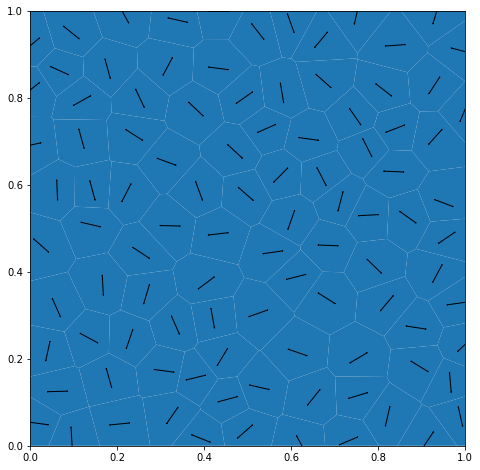

In [7]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
pmesh = microstructpy.meshing.PolyMesh.from_file("microstructure.txt")
pmesh.plot()

# plt.scatter(centers[:, 0], centers[:, 1], color='black', s=1)
arrow_length = 0.03 # You can adjust this based on your plot's scale

for center, angle in zip(centers, theta0):
    dx = arrow_length * np.cos(angle)
    dy = arrow_length * np.sin(angle)
    arrow = matplotlib.patches.FancyArrowPatch((center[0]-dx, center[1]-dy),
                                               (center[0] + dx, center[1] + dy),
                                               arrowstyle='<|-|>', lw=1, color='black')
    ax.add_patch(arrow)

In [8]:
def solve_heat_equation(dt, steps, dirichlet_bcs):
    assembler = femns2d.MiniAssembler(mesh)
    assembler.set_main_element("linear")
    K = assembler.stiffness_matrix(stiffness_fn=stiffness_fn, stiffness_fn_type='element')
    M = assembler.mass_matrix()
    MKdt = M + dt*K
    MKdt = assembler.apply_dirichlet_to_matrix(dirichlet_bcs[1], MKdt, where='u', data_dict_name="grain")
    
    Tvalues = []
    T = np.zeros(assembler.nvariables)
    T = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, T, where='u', data_dict_name="grain")
    Tvalues.append(T.copy())

    MKdt = MKdt.tocsc()
    LU = scipy.sparse.linalg.splu(MKdt)
    
    for i in range(steps):
        f = M@T
        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, f, where='u', data_dict_name="grain")
        MKdt = MKdt.tocsc()
        T = LU.solve(f)
        Tvalues.append(T.copy())
    T = np.array(Tvalues)
    t = np.arange(steps)*dt
    
    return T, t

In [9]:
tictoc = pytictoc.TicToc()
for sample in range(10, 30):
    mainpath = pathlib.Path("results_heat")
    filename = f"res_m0_random_{sample}.npz"
    savename = mainpath/filename

    lambdamax = 1.0
    lambdamin = 0.1
    theta0 = np.random.rand(len(np.unique(grain_markers)))*2*np.pi
    theta_markers = np.array([theta0[marker] for marker in grain_markers])
    def stiffness_fn(i):
        theta = theta_markers[i]
        Q = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        D = np.diag([lambdamax, lambdamin])
        return Q@D@(Q.T)
    
    tictoc.tic()
    T, t = solve_heat_equation(1e-3, 10001, [[1], [3]])
    tictoc.toc()
    np.savez(savename, T=T, t=t, theta0=theta0)

Elapsed time is 183.796292 seconds.
Elapsed time is 189.233467 seconds.
Elapsed time is 210.882654 seconds.
Elapsed time is 169.237994 seconds.
Elapsed time is 168.283011 seconds.
Elapsed time is 166.197496 seconds.
Elapsed time is 166.951077 seconds.
Elapsed time is 166.610957 seconds.
Elapsed time is 192.822606 seconds.
Elapsed time is 197.546315 seconds.
Elapsed time is 198.878395 seconds.
Elapsed time is 199.518758 seconds.
Elapsed time is 199.456585 seconds.
Elapsed time is 202.513884 seconds.
Elapsed time is 201.331788 seconds.
Elapsed time is 201.815864 seconds.
Elapsed time is 200.433786 seconds.
Elapsed time is 203.399045 seconds.
Elapsed time is 202.376928 seconds.
Elapsed time is 204.110331 seconds.
